In [ ]:
#          #####################################################################################
#          #                                  IN THE NAME OF ALLAH                             #
#          #   [1] FREE VIBRATION ANAYSIS OF ELASTIC SPRING                                    #
#          #   [2] FREE VIBRATION ANAYSIS OF INELASTIC SPRING                                  #
#          #   [3] FREE VIBRATION ANAYSIS OF INELASTIC SPRING WITH TRIGONOMETRIC LOADING       #
#          #   [4] FREE VIBRATION ANAYSIS OF INELASTIC SPRING WITH TRIANGULAR LOADING          #
#          #   [5] FREE VIBRATION ANAYSIS OF INELASTIC SPRING WITH RECTANGULAR LOADING         #
#          #   [6] FREE VIBRATION ANAYSIS OF INELASTIC SPRING WITH PULSE LOADING               #
#          #-----------------------------------------------------------------------------------#
#          #              THIS PROGRAM WRITTEN BY SALAR DELAVAR GHASHGHAEI (QASHQAI)           #
#          #                       EMAIL: salar.d.ghashghaei@gmail.com                         #
#          #####################################################################################

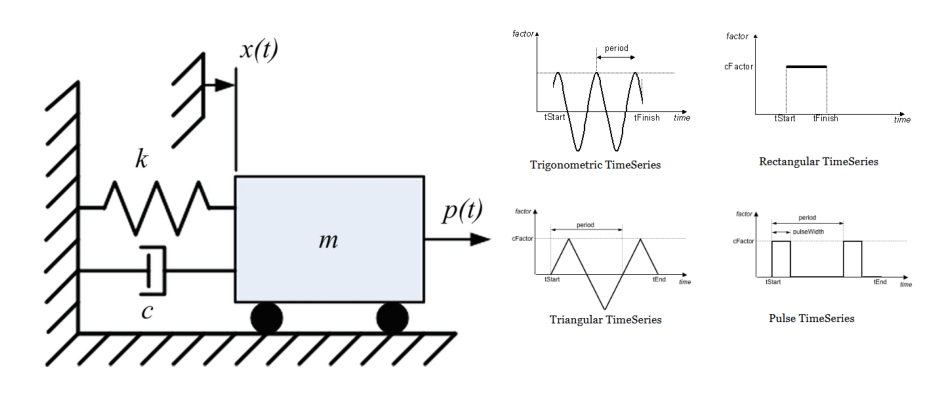

In [1]:
# Load the image
def PLOT_IMAGE(image):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    image = mpimg.imread(image_path)

    # Display the image
    plt.figure(figsize=(12, 10))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()
    
image_path = 'OPENSEES_FREE_VIBRATION.png'       
PLOT_IMAGE(image_path)

In [1]:
def PLOT_4_CHART():
    # Plot the results
    plt.figure(figsize=(18, 20))
    # Displacement
    plt.subplot(4, 1, 1) 
    plt.plot(time_undamped, displacement_undamped, label='Undamped', color='black') 
    plt.plot(time_damped, displacement_damped, label='Damped', color='red') 
    plt.xlabel('Time [s]') 
    plt.ylabel('Displacement ') 
    plt.title('Displacement Time History') 
    plt.legend()
    # Velocity
    plt.subplot(4, 1, 2) 
    plt.plot(time_undamped, velocity_undamped, label='Undamped', color='black') 
    plt.plot(time_damped, velocity_damped, label='Damped', color='red') 
    plt.xlabel('Time [s]') 
    plt.ylabel('Velocity') 
    plt.title('Velocity Time History') 
    plt.legend()
    # Acceleration
    plt.subplot(4, 1, 3) 
    plt.plot(time_undamped, acceleration_undamped, label='Undamped', color='black') 
    plt.plot(time_damped, acceleration_damped, label='Damped', color='red') 
    plt.xlabel('Time [s]') 
    plt.ylabel('Acceleration') 
    plt.title('Acceleration Time History') 
    plt.legend()
    # Spring Force
    plt.subplot(4, 1, 4) 
    plt.plot(time_undamped, spring_force_undamped, label='Undamped', color='black') 
    plt.plot(time_damped, spring_force_damped, label='Damped', color='red') 
    plt.xlabel('Time [s]') 
    plt.ylabel('Spring Force') 
    plt.title('Spring Force Time History') 
    plt.legend()
    # Display the plot
    plt.show()

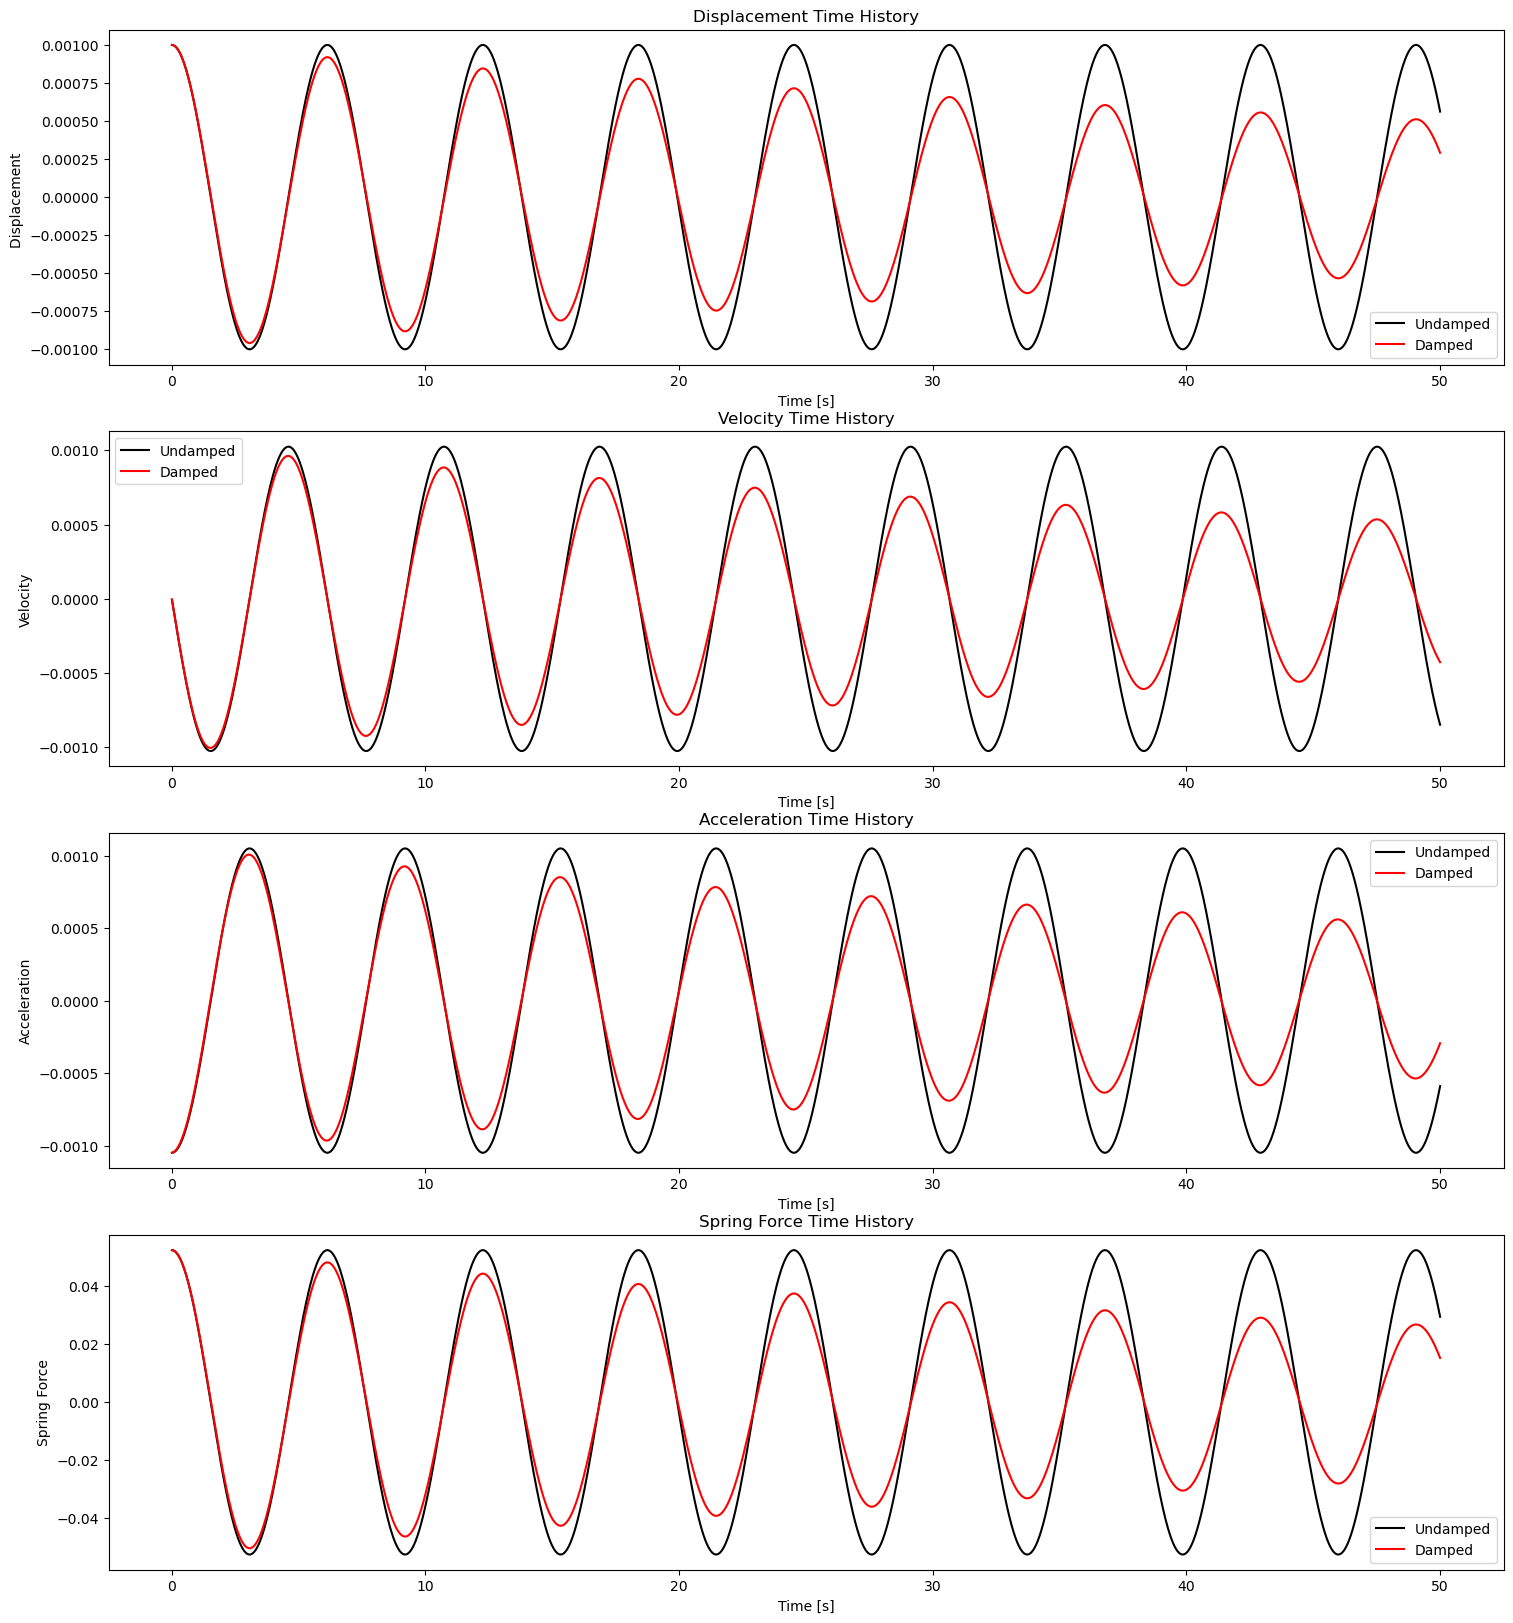

In [4]:
#          #####################################################################################
#          #                                  IN THE NAME OF ALLAH                             #
#          #                           FREE VIBRATION ANAYSIS OF ELASTIC SPRING                #
#          #-----------------------------------------------------------------------------------#
#          #              THIS PROGRAM WRITTEN BY SALAR DELAVAR GHASHGHAEI (QASHQAI)           #
#          #                       EMAIL: salar.d.ghashghaei@gmail.com                         #
#          #####################################################################################

import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt

# Set up variables
e = 210.0e3  # Modulus of elasticity (Young's modulus)
A = 0.25  # Cross-sectional area of the element
l = 1000.0  # Length of the element
k = (e*A)/l # Truss Axial Stiffness
m = 50.0  # Mass of the node
u0 = 0.001  # Initial displacement applied to the node
damping_ratio = 0.02  # Damping ratio

# Set analysis parameters
duration = 50.0 # [s] 50 Seconds
dt = 0.01 # time step

# Function to perform transient analysis
def perform_analysis(damping=False):
    # Set up the model
    ops.wipe()
    ops.model('basic', '-ndm', 2, '-ndf', 3)

    # Define nodes
    ops.node(1, 0, 0)
    ops.node(2, l, 0)

    # Define boundary conditions
    ops.fix(1, 1, 1, 1)
    ops.fix(2, 0, 1, 1)

    # Define mass
    ops.mass(2, m, 0, 0)

    # Define material
    ops.uniaxialMaterial('Elastic', 1, e)

    # Define element
    ops.element('Truss', 1, 1, 2, A, 1)

    # Static analysis to apply initial displacement
    ops.timeSeries('Linear', 1)
    ops.pattern('Plain', 1, 1)
    ops.load(2, 1.0, 0, 0)

    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('BandGeneral')
    ops.algorithm('Newton')
    ops.test('NormDispIncr', 1.0e-8, 10)
    ops.integrator('DisplacementControl', 2, 1, u0)
    ops.analysis('Static')
    ops.analyze(1)

    ops.setTime(0.0)

    # Wipe analysis and reset time
    ops.wipeAnalysis()
    ops.remove('loadPattern', 1)
    ops.system('UmfPack')

    # Dynamic analysis
    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('UmfPack')
    ops.test('NormDispIncr', 1.0e-8, 10)
    ops.integrator('Newmark', 0.5, 0.25)
    ops.algorithm('Newton')

    if damping:
        # Calculate Rayleigh damping factors
        omega1 = np.sqrt(k / m)
        omega2 = 2 * omega1  # Just an assumption for two modes
        a0 = damping_ratio * (2 * omega1 * omega2) / (omega1 + omega2)
        a1 = damping_ratio * 2 / (omega1 + omega2)
        # Apply Rayleigh damping
        ops.rayleigh(a0, a1, 0, 0)

    ops.analysis('Transient')

    # Perform transient analysis and store results
    time = []
    displacement = []
    velocity = []
    acceleration = []
    spring_force = []

    stable = 0
    current_time = 0.0

    while stable == 0 and current_time < duration:
        stable = ops.analyze(1, dt)
        current_time = ops.getTime()
        time.append(current_time)
        displacement.append(ops.nodeDisp(2, 1))
        velocity.append(ops.nodeVel(2, 1))
        acceleration.append(ops.nodeAccel(2, 1))
        spring_force.append(-ops.eleResponse(1, 'force')[0])

    return time, displacement, velocity, acceleration, spring_force

# Perform analyses
time_undamped, displacement_undamped, velocity_undamped, acceleration_undamped, spring_force_undamped = perform_analysis(damping=False)
time_damped, displacement_damped, velocity_damped, acceleration_damped, spring_force_damped = perform_analysis(damping=True)

### PLOT THE TIME HISTORY:
PLOT_4_CHART()

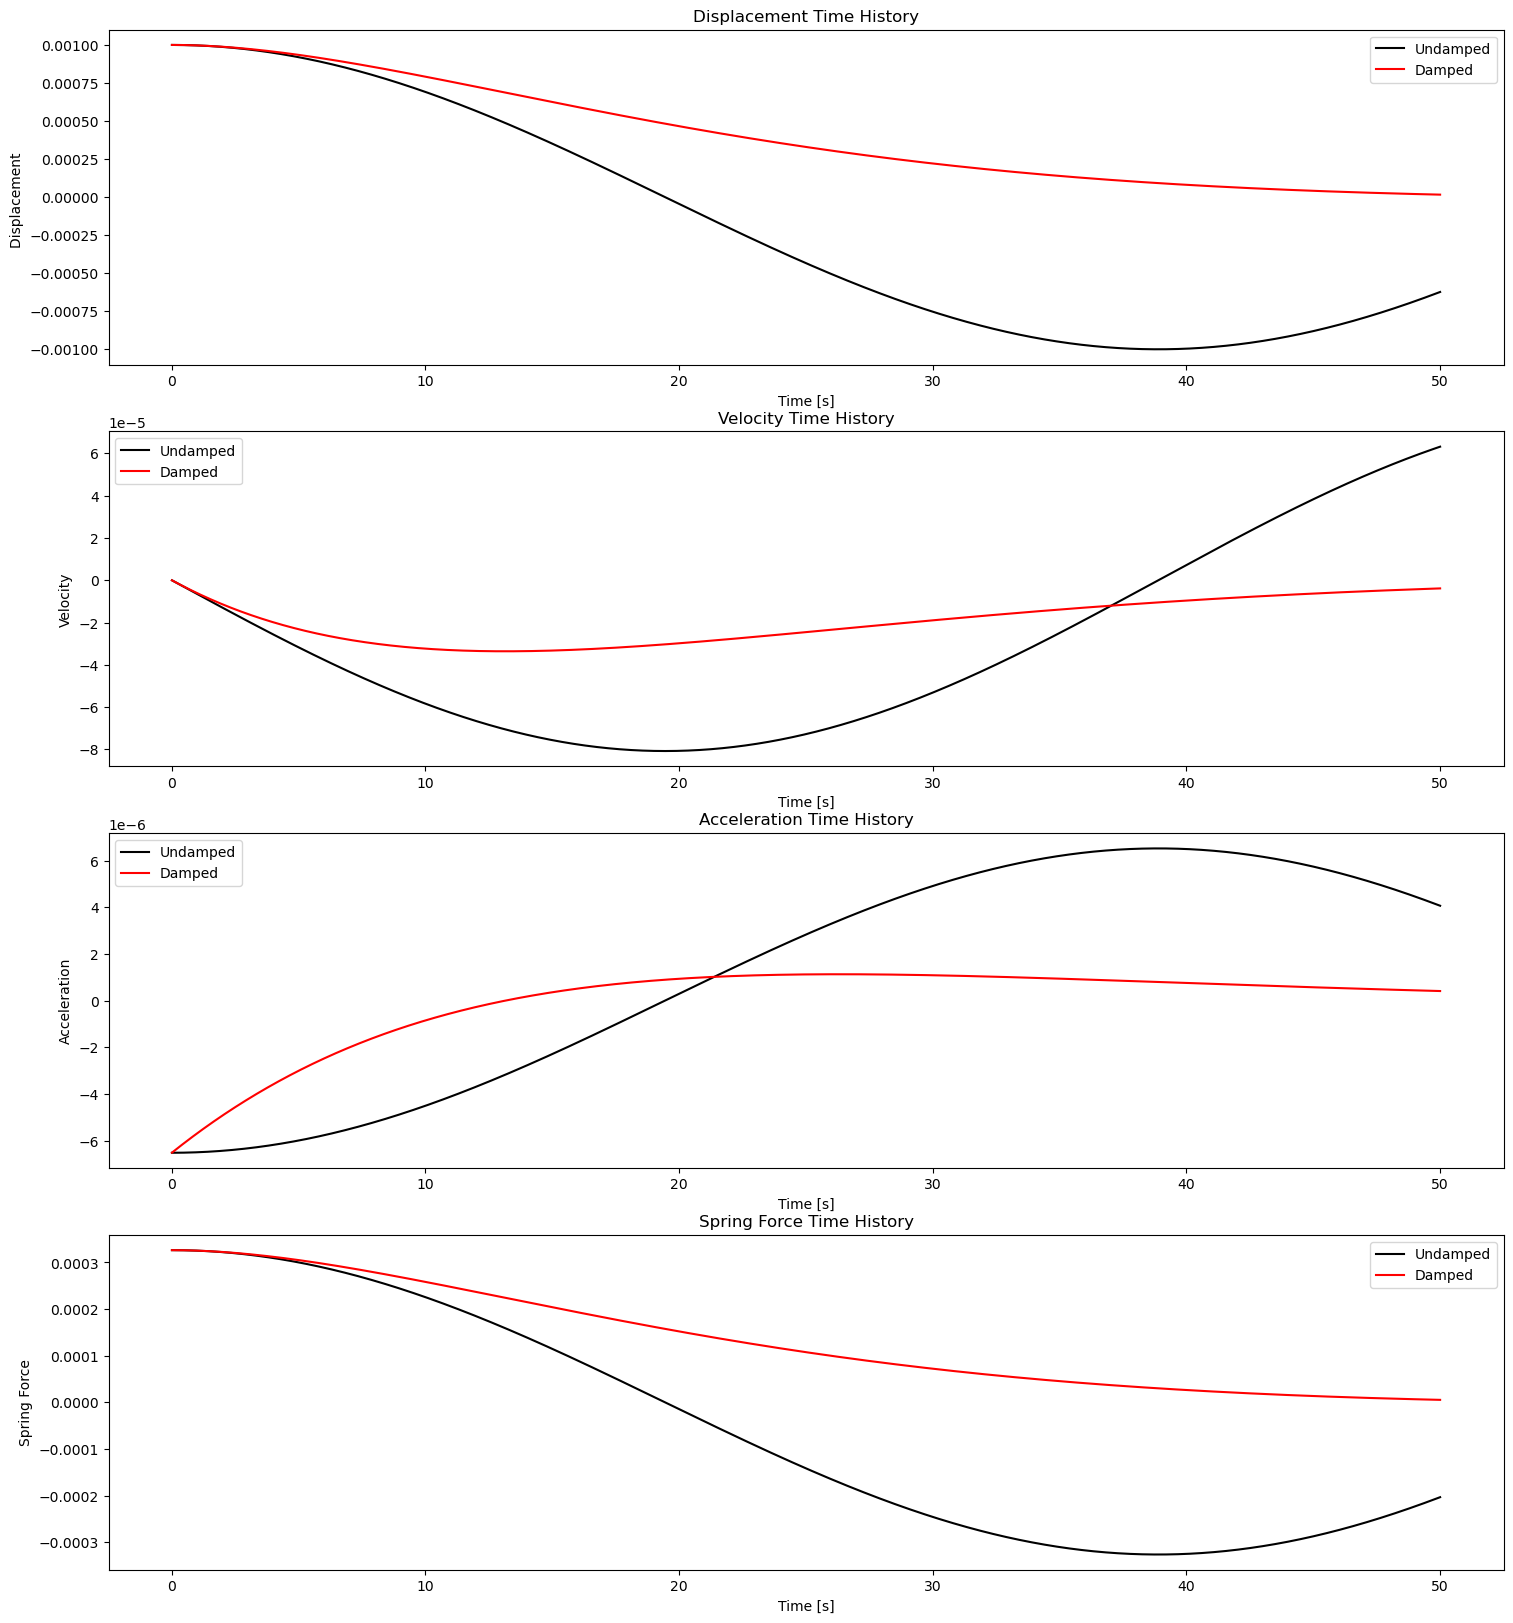

In [10]:
#          #####################################################################################
#          #                                  IN THE NAME OF ALLAH                             #
#          #                      FREE VIBRATION ANAYSIS OF INELASTIC SPRING                   #
#          #-----------------------------------------------------------------------------------#
#          #              THIS PROGRAM WRITTEN BY SALAR DELAVAR GHASHGHAEI (QASHQAI)           #
#          #                       EMAIL: salar.d.ghashghaei@gmail.com                         #
#          #####################################################################################

import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt

# Set up variables
e = 210.0e3  # Modulus of elasticity (Young's modulus)
A = 0.25  # Cross-sectional area of the element
l = 1000.0  # Length of the element
k = (e*A)/l # Truss Axial Stiffness
m = 50.0  # Mass of the node
u0 = 0.001  # Initial displacement applied to the node
damping_ratio = 0.02  # Damping ratio

# Set analysis parameters
duration = 50.0 # [s] 50 Seconds
dt = 0.01 # time step

# Define ReinforcingSteel material properties
fy = 400.0  # Yield strength of steel
Es = 210.0e3  # Modulus of elasticity
fu = 600.0  # Ultimate strength
Esh = 20.0e3  # Hardening modulus
esh = 0.01  # Strain at start of hardening
esu = 0.1  # Ultimate strain

def perform_analysis(damping=False):
    # Set up the model
    ops.wipe()
    ops.model('basic', '-ndm', 2, '-ndf', 3)

    # Define nodes
    ops.node(1, 0, 0)
    ops.node(2, l, 0)

    # Define boundary conditions
    ops.fix(1, 1, 1, 1)
    ops.fix(2, 0, 1, 1)

    # Define mass
    ops.mass(2, m, 0, 0)

    # Define material
    ops.uniaxialMaterial('ReinforcingSteel', 1, fy, Es, fu, Esh, esh, esu)

    # Define element
    ops.element('Truss', 1, 1, 2, A, 1)

    # Static analysis to apply initial displacement
    ops.timeSeries('Linear', 1)
    ops.pattern('Plain', 1, 1)
    ops.load(2, 1.0, 0, 0)

    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('BandGeneral')
    ops.algorithm('Newton')
    ops.test('NormDispIncr', 1.0e-8, 10)
    ops.integrator('DisplacementControl', 2, 1, u0)
    ops.analysis('Static')
    ops.analyze(1)

    ops.setTime(0.0)

    # Wipe analysis and reset time
    ops.wipeAnalysis()
    ops.remove('loadPattern', 1)
    ops.system('UmfPack')

    # Dynamic analysis
    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('UmfPack')
    ops.test('NormDispIncr', 1.0e-8, 10)
    ops.integrator('Newmark', 0.5, 0.25)
    ops.algorithm('Newton')

    if damping:
        # Calculate Rayleigh damping factors
        omega1 = np.sqrt(k / m)
        omega2 = 2 * omega1  # Just an assumption for two modes
        a0 = damping_ratio * (2 * omega1 * omega2) / (omega1 + omega2)
        a1 = damping_ratio * 2 / (omega1 + omega2)
        # Apply Rayleigh damping
        ops.rayleigh(a0, a1, 0, 0)

    ops.analysis('Transient')

    # Perform transient analysis and store results
    time = []
    displacement = []
    velocity = []
    acceleration = []
    spring_force = []

    stable = 0
    current_time = 0.0

    while stable == 0 and current_time < duration:
        stable = ops.analyze(1, dt)
        current_time = ops.getTime()
        time.append(current_time)
        displacement.append(ops.nodeDisp(2, 1))
        velocity.append(ops.nodeVel(2, 1))
        acceleration.append(ops.nodeAccel(2, 1))
        spring_force.append(-ops.eleResponse(1, 'force')[0])

    return time, displacement, velocity, acceleration, spring_force

# Perform analyses
time_undamped, displacement_undamped, velocity_undamped, acceleration_undamped, spring_force_undamped = perform_analysis(damping=False)
time_damped, displacement_damped, velocity_damped, acceleration_damped, spring_force_damped = perform_analysis(damping=True)

### PLOT THE TIME HISTORY:
PLOT_4_CHART()

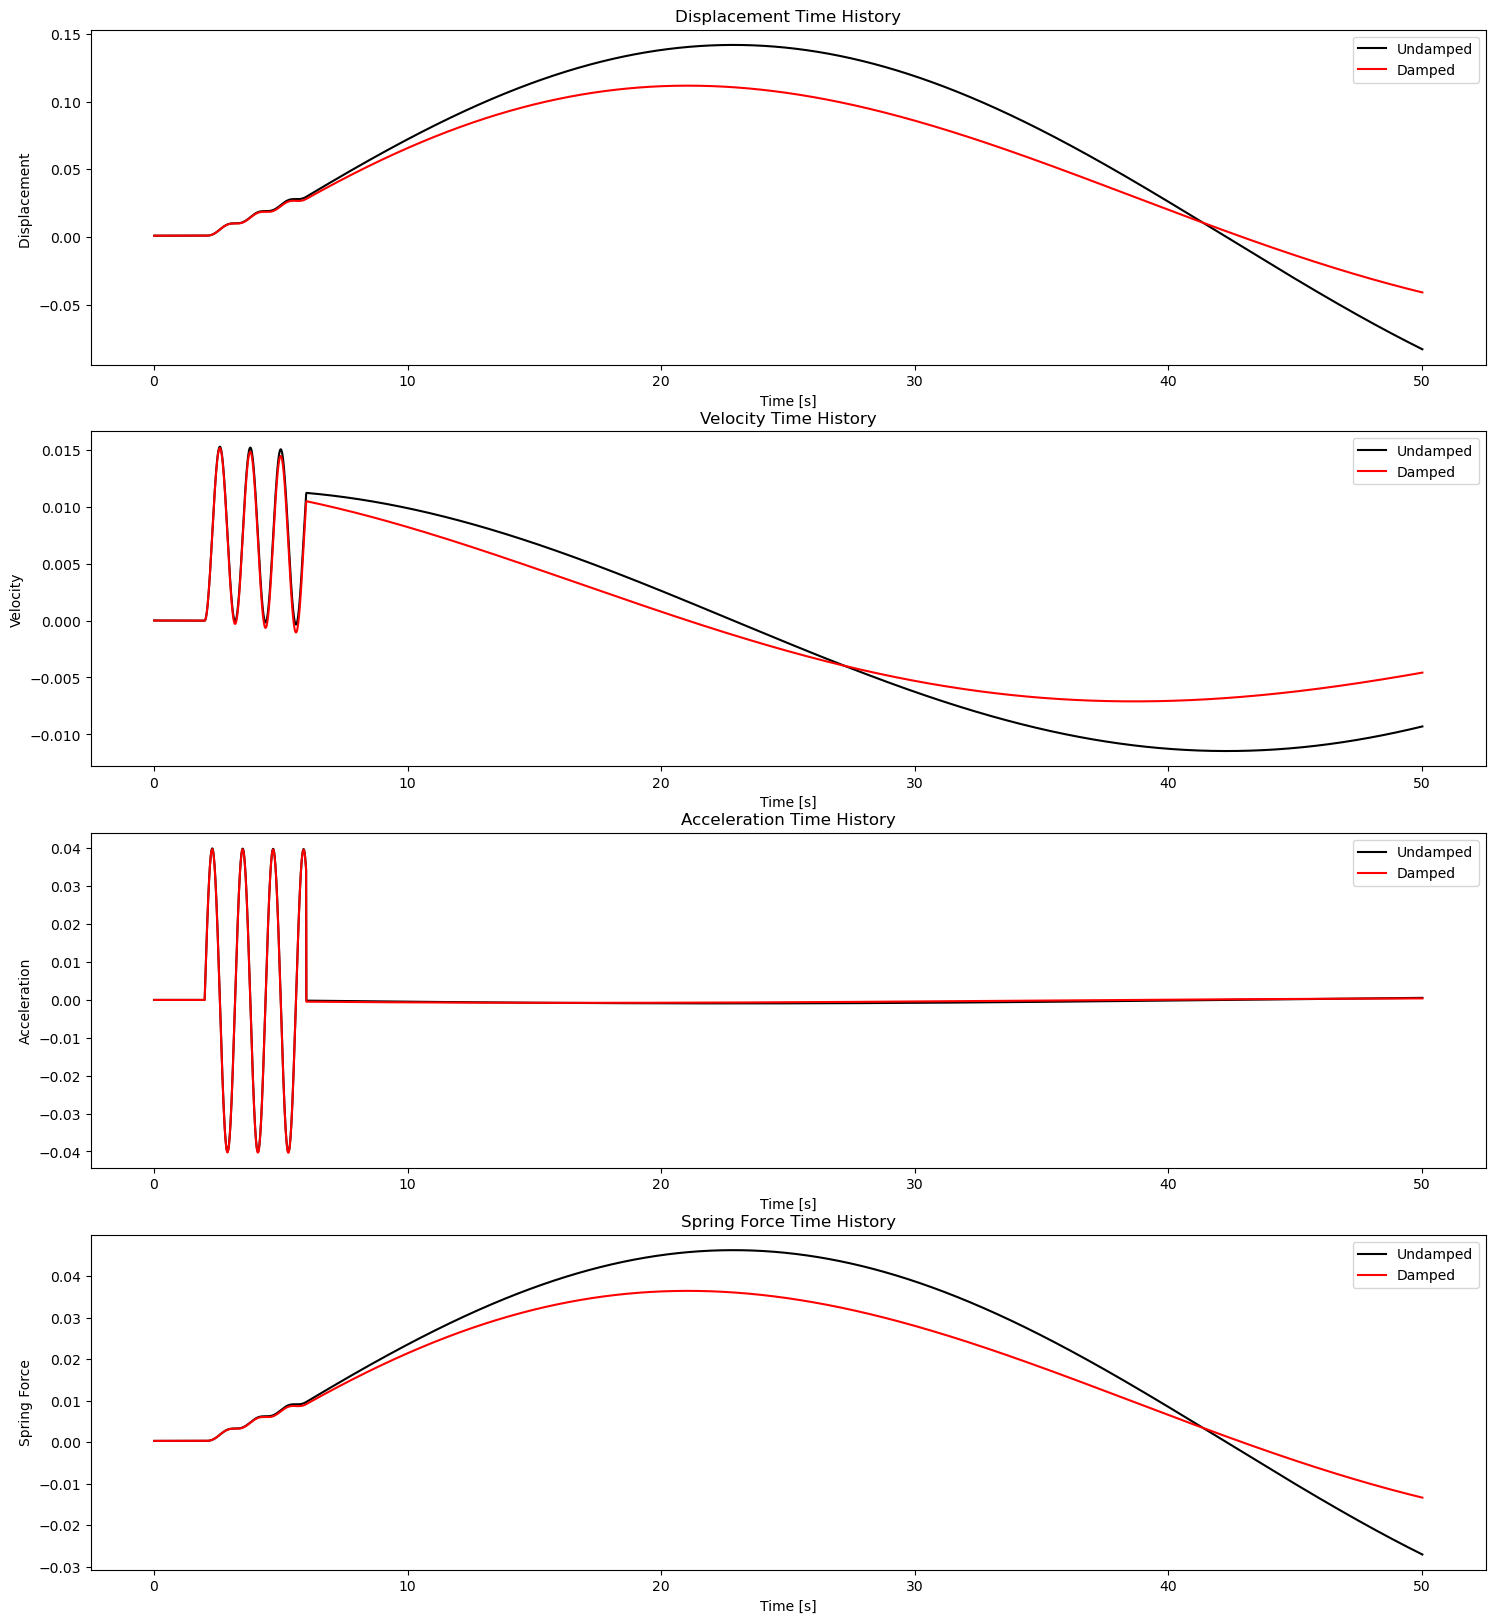

In [5]:
#          #####################################################################################
#          #                                  IN THE NAME OF ALLAH                             #
#          #       FREE VIBRATION ANAYSIS OF INELASTIC SPRING WITH TRIGONOMETRIC LOADING       #
#          #-----------------------------------------------------------------------------------#
#          #              THIS PROGRAM WRITTEN BY SALAR DELAVAR GHASHGHAEI (QASHQAI)           #
#          #                       EMAIL: salar.d.ghashghaei@gmail.com                         #
#          #####################################################################################

import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt

# Set up variables
e = 210.0e3  # Modulus of elasticity (Young's modulus)
A = 0.25  # Cross-sectional area of the element
l = 1000.0  # Length of the element
k = (e*A)/l # Truss Axial Stiffness
m = 50.0  # Mass of the node
u0 = 0.001  # Initial displacement applied to the node
damping_ratio = 0.02  # Damping ratio

# Set analysis parameters
duration = 50.0 # [s] 50 Seconds
dt = 0.01 # time step

# Define ReinforcingSteel material properties
fy = 400.0  # Yield strength of steel
Es = 210.0e3  # Modulus of elasticity
fu = 600.0  # Ultimate strength
Esh = 20.0e3  # Hardening modulus
esh = 0.01  # Strain at start of hardening
esu = 0.1  # Ultimate strain

# Trigonometric (Harmonic) loading parameters
START_TIME = 2.0
END_TIME = 6.0
PERIOD = 1.2
LOAD_FACTOR = 2.0 # Amplitude Factor

def perform_analysis(damping=False):
    # Set up the model
    ops.wipe()
    ops.model('basic', '-ndm', 2, '-ndf', 3)

    # Define nodes
    ops.node(1, 0, 0)
    ops.node(2, l, 0)

    # Define boundary conditions
    ops.fix(1, 1, 1, 1)
    ops.fix(2, 0, 1, 1)

    # Define mass
    ops.mass(2, m, 0, 0)

    # Define material
    ops.uniaxialMaterial('ReinforcingSteel', 1, fy, Es, fu, Esh, esh, esu)

    # Define element
    ops.element('Truss', 1, 1, 2, A, 1)

    # Static analysis to apply initial displacement
    ops.timeSeries('Linear', 1)
    ops.pattern('Plain', 1, 1)
    ops.load(2, 1.0, 0, 0)

    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('BandGeneral')
    ops.algorithm('Newton')
    ops.test('NormDispIncr', 1.0e-8, 10)
    ops.integrator('DisplacementControl', 2, 1, u0)
    ops.analysis('Static')
    ops.analyze(1)

    ops.setTime(0.0)

    # Wipe analysis and reset time
    ops.wipeAnalysis()
    ops.remove('loadPattern', 1)
    ops.system('UmfPack')
    # Define harmonic loading
    ops.timeSeries('Trig', 2, START_TIME, END_TIME, PERIOD, '-factor', LOAD_FACTOR)
    ops.pattern('Plain', 2, 2)
    ops.load(2, 1.0, 0, 0)

    # Dynamic analysis
    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('UmfPack')
    ops.test('NormDispIncr', 1.0e-8, 10)
    ops.integrator('Newmark', 0.5, 0.25)
    ops.algorithm('Newton')

    if damping:
        # Calculate Rayleigh damping factors
        omega1 = np.sqrt(k / m)
        omega2 = 2 * omega1  # Just an assumption for two modes
        a0 = damping_ratio * (2 * omega1 * omega2) / (omega1 + omega2)
        a1 = damping_ratio * 2 / (omega1 + omega2)
        # Apply Rayleigh damping
        ops.rayleigh(a0, a1, 0, 0)

    ops.analysis('Transient')

    # Perform transient analysis and store results
    time = []
    displacement = []
    velocity = []
    acceleration = []
    spring_force = []

    stable = 0
    current_time = 0.0

    while stable == 0 and current_time < duration:
        stable = ops.analyze(1, dt)
        current_time = ops.getTime()
        time.append(current_time)
        displacement.append(ops.nodeDisp(2, 1))
        velocity.append(ops.nodeVel(2, 1))
        acceleration.append(ops.nodeAccel(2, 1))
        spring_force.append(-ops.eleResponse(1, 'force')[0])

    return time, displacement, velocity, acceleration, spring_force

# Perform analyses
time_undamped, displacement_undamped, velocity_undamped, acceleration_undamped, spring_force_undamped = perform_analysis(damping=False)
time_damped, displacement_damped, velocity_damped, acceleration_damped, spring_force_damped = perform_analysis(damping=True)

### PLOT THE TIME HISTORY:
PLOT_4_CHART()

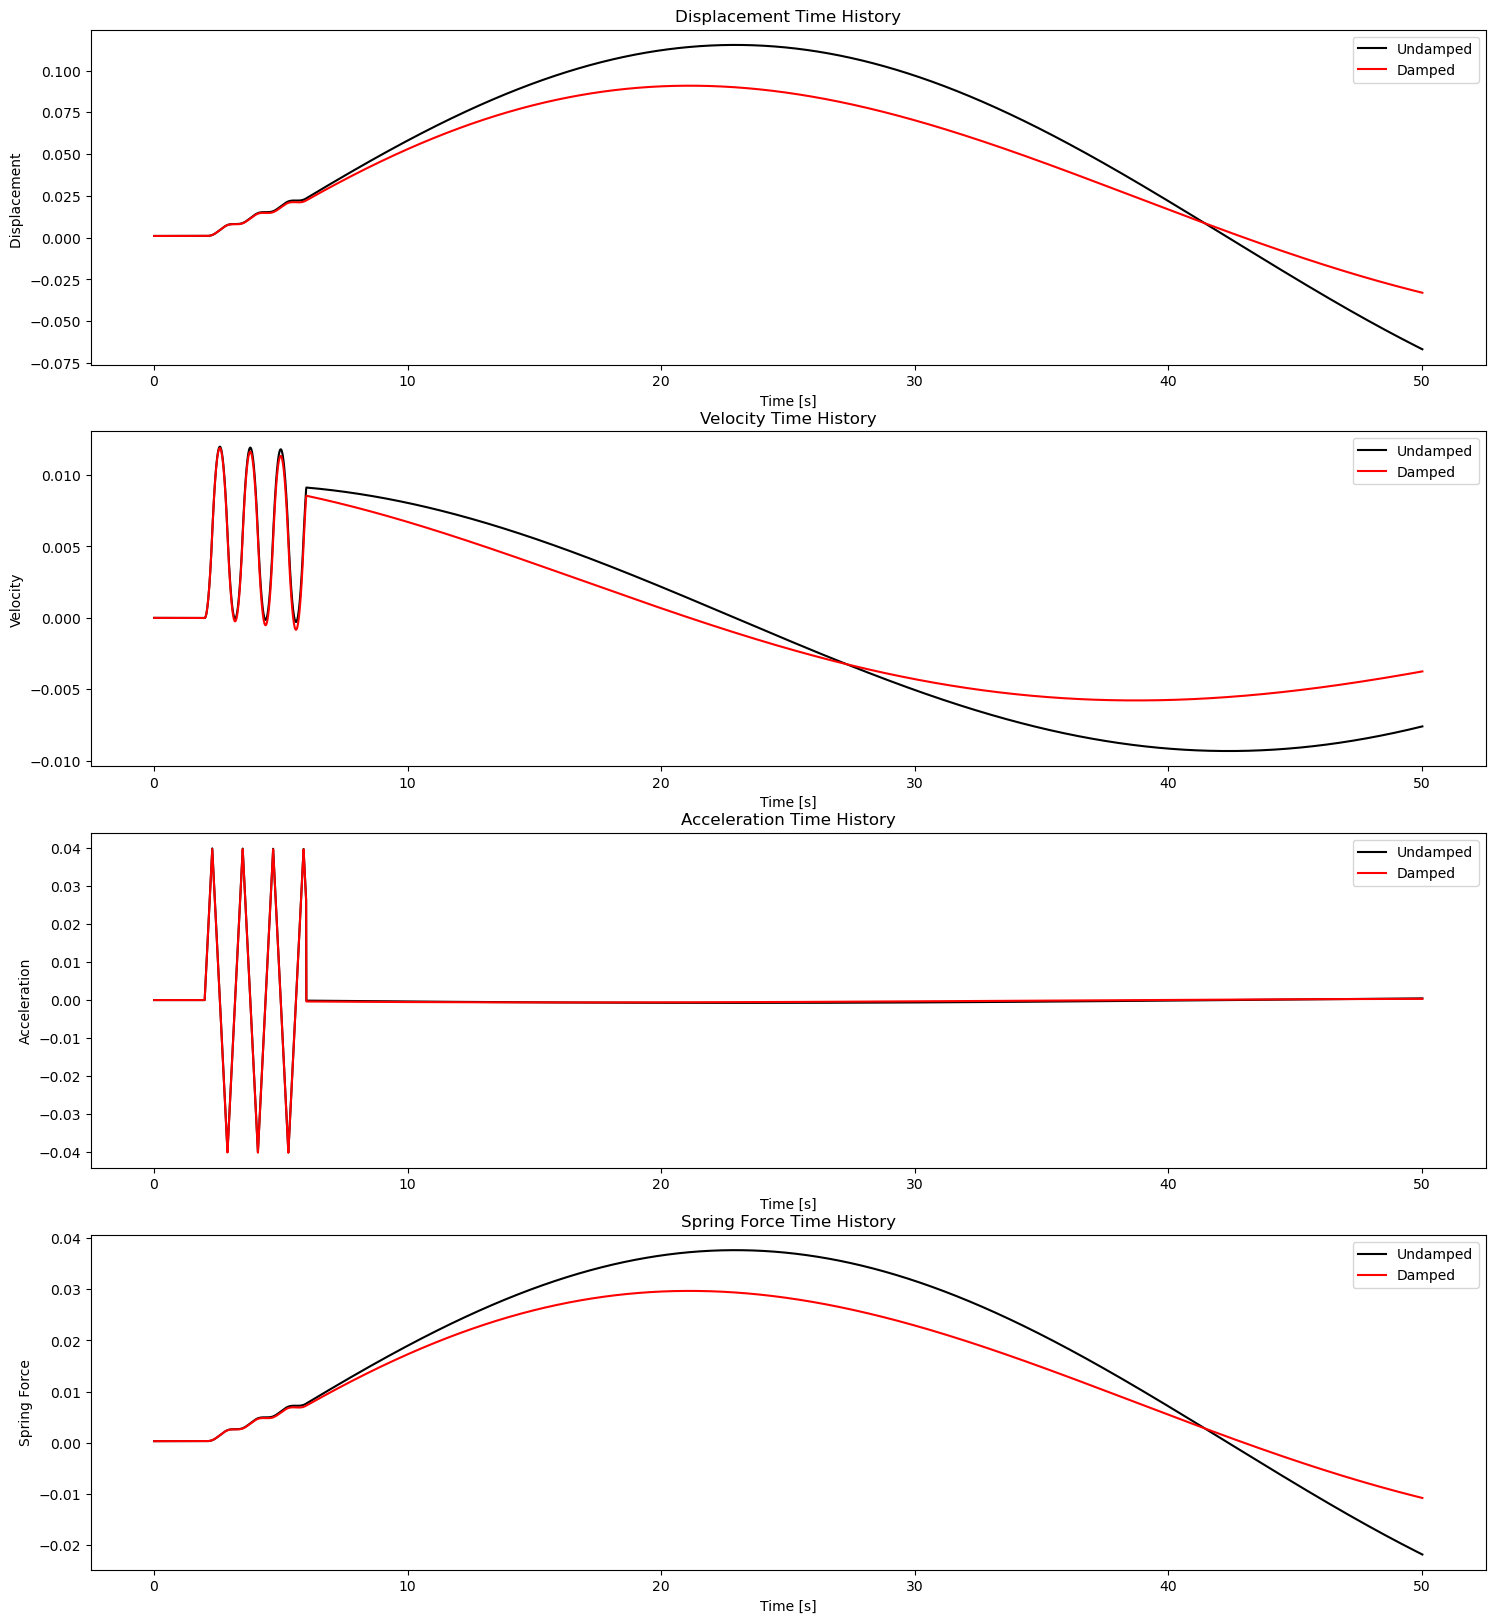

In [6]:
#          #####################################################################################
#          #                                  IN THE NAME OF ALLAH                             #
#          #         FREE VIBRATION ANAYSIS OF INELASTIC SPRING WITH TRIANGULAR LOADING        #
#          #-----------------------------------------------------------------------------------#
#          #              THIS PROGRAM WRITTEN BY SALAR DELAVAR GHASHGHAEI (QASHQAI)           #
#          #                       EMAIL: salar.d.ghashghaei@gmail.com                         #
#          #####################################################################################

import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt

# Set up variables
e = 210.0e3  # Modulus of elasticity (Young's modulus)
A = 0.25  # Cross-sectional area of the element
l = 1000.0  # Length of the element
k = (e*A)/l # Truss Axial Stiffness
m = 50.0  # Mass of the node
u0 = 0.001  # Initial displacement applied to the node
damping_ratio = 0.02  # Damping ratio

# Set analysis parameters
duration = 50.0 # [s] 50 Seconds
dt = 0.01 # time step

# Define ReinforcingSteel material properties
fy = 400.0  # Yield strength of steel
Es = 210.0e3  # Modulus of elasticity
fu = 600.0  # Ultimate strength
Esh = 20.0e3  # Hardening modulus
esh = 0.01  # Strain at start of hardening
esu = 0.1  # Ultimate strain

# Triangle loading parameters
START_TIME = 2.0
END_TIME = 6.0
PERIOD = 1.2
LOAD_FACTOR = 2.0  # Amplitude Factor

def perform_analysis(damping=False):
    # Set up the model
    ops.wipe()
    ops.model('basic', '-ndm', 2, '-ndf', 3)

    # Define nodes
    ops.node(1, 0, 0)
    ops.node(2, l, 0)

    # Define boundary conditions
    ops.fix(1, 1, 1, 1)
    ops.fix(2, 0, 1, 1)

    # Define mass
    ops.mass(2, m, 0, 0)

    # Define material
    ops.uniaxialMaterial('ReinforcingSteel', 1, fy, Es, fu, Esh, esh, esu)

    # Define element
    ops.element('Truss', 1, 1, 2, A, 1)

    # Static analysis to apply initial displacement
    ops.timeSeries('Linear', 1)
    ops.pattern('Plain', 1, 1)
    ops.load(2, 1.0, 0, 0)

    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('BandGeneral')
    ops.algorithm('Newton')
    ops.test('NormDispIncr', 1.0e-8, 10)
    ops.integrator('DisplacementControl', 2, 1, u0)
    ops.analysis('Static')
    ops.analyze(1)

    ops.setTime(0.0)

    # Wipe analysis and reset time
    ops.wipeAnalysis()
    ops.remove('loadPattern', 1)
    ops.system('UmfPack')
    # Define triangle loading 
    ops.timeSeries('Triangle', 2, START_TIME, END_TIME, PERIOD, '-factor', LOAD_FACTOR)
    ops.pattern('Plain', 2, 2)
    ops.load(2, 1.0, 0, 0)

    # Dynamic analysis
    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('UmfPack')
    ops.test('NormDispIncr', 1.0e-8, 10)
    ops.integrator('Newmark', 0.5, 0.25)
    ops.algorithm('Newton')

    if damping:
        # Calculate Rayleigh damping factors
        omega1 = np.sqrt(k / m)
        omega2 = 2 * omega1  # Just an assumption for two modes
        a0 = damping_ratio * (2 * omega1 * omega2) / (omega1 + omega2)
        a1 = damping_ratio * 2 / (omega1 + omega2)
        # Apply Rayleigh damping
        ops.rayleigh(a0, a1, 0, 0)

    ops.analysis('Transient')

    # Perform transient analysis and store results
    time = []
    displacement = []
    velocity = []
    acceleration = []
    spring_force = []

    stable = 0
    current_time = 0.0

    while stable == 0 and current_time < duration:
        stable = ops.analyze(1, dt)
        current_time = ops.getTime()
        time.append(current_time)
        displacement.append(ops.nodeDisp(2, 1))
        velocity.append(ops.nodeVel(2, 1))
        acceleration.append(ops.nodeAccel(2, 1))
        spring_force.append(-ops.eleResponse(1, 'force')[0])

    return time, displacement, velocity, acceleration, spring_force

# Perform analyses
time_undamped, displacement_undamped, velocity_undamped, acceleration_undamped, spring_force_undamped = perform_analysis(damping=False)
time_damped, displacement_damped, velocity_damped, acceleration_damped, spring_force_damped = perform_analysis(damping=True)

### PLOT THE TIME HISTORY:
PLOT_4_CHART()

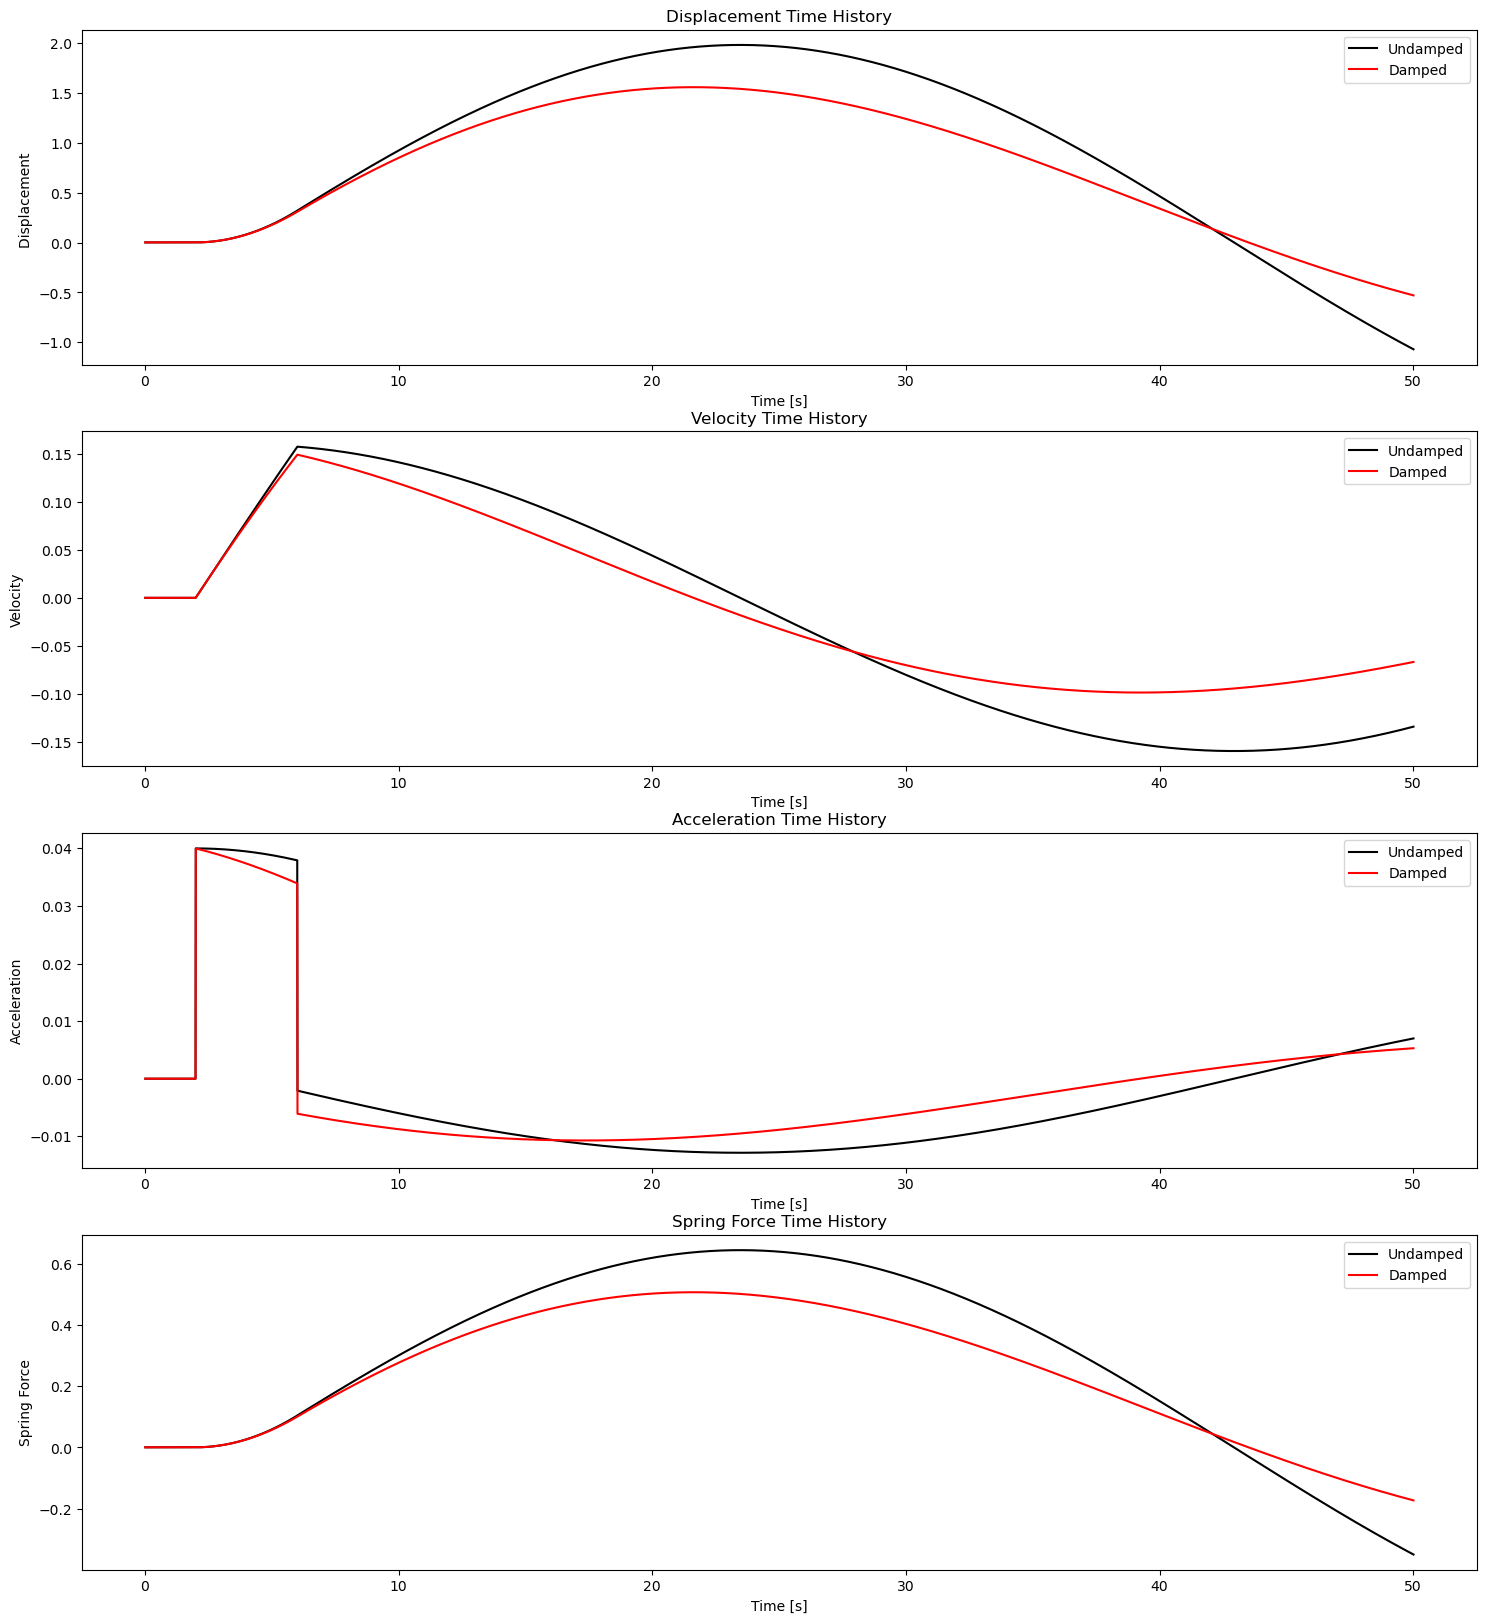

In [7]:
#          #####################################################################################
#          #                                  IN THE NAME OF ALLAH                             #
#          #       FREE VIBRATION ANAYSIS OF INELASTIC SPRING WITH RECTANGULAR LOADING         #
#          #-----------------------------------------------------------------------------------#
#          #              THIS PROGRAM WRITTEN BY SALAR DELAVAR GHASHGHAEI (QASHQAI)           #
#          #                       EMAIL: salar.d.ghashghaei@gmail.com                         #
#          #####################################################################################

import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt

# Set up variables
e = 210.0e3  # Modulus of elasticity (Young's modulus)
A = 0.25  # Cross-sectional area of the element
l = 1000.0  # Length of the element
k = (e*A)/l # Truss Axial Stiffness
m = 50.0  # Mass of the node
u0 = 0.001  # Initial displacement applied to the node
damping_ratio = 0.02  # Damping ratio

# Set analysis parameters
duration = 50.0 # [s] 50 Seconds
dt = 0.01 # time step

# Define ReinforcingSteel material properties
fy = 400.0  # Yield strength of steel
Es = 210.0e3  # Modulus of elasticity
fu = 600.0  # Ultimate strength
Esh = 20.0e3  # Hardening modulus
esh = 0.01  # Strain at start of hardening
esu = 0.1  # Ultimate strain

# Rectangular loading parameters
START_TIME = 2.0
END_TIME = 6.0
PERIOD = 1.2
LOAD_FACTOR = 2.0  # Amplitude Factor

def perform_analysis(damping=False):
    # Set up the model
    ops.wipe()
    ops.model('basic', '-ndm', 2, '-ndf', 3)

    # Define nodes
    ops.node(1, 0, 0)
    ops.node(2, l, 0)

    # Define boundary conditions
    ops.fix(1, 1, 1, 1)
    ops.fix(2, 0, 1, 1)

    # Define mass
    ops.mass(2, m, 0, 0)

    # Define material
    ops.uniaxialMaterial('ReinforcingSteel', 1, fy, Es, fu, Esh, esh, esu)

    # Define element
    ops.element('Truss', 1, 1, 2, A, 1)

    # Static analysis to apply initial displacement
    ops.timeSeries('Linear', 1)
    ops.pattern('Plain', 1, 1)
    ops.load(2, 1.0, 0, 0)

    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('BandGeneral')
    ops.algorithm('Newton')
    ops.test('NormDispIncr', 1.0e-8, 10)
    ops.integrator('DisplacementControl', 2, 1, u0)
    ops.analysis('Static')
    ops.analyze(1)

    ops.setTime(0.0)

    # Wipe analysis and reset time
    ops.wipeAnalysis()
    ops.remove('loadPattern', 1)
    ops.system('UmfPack')
    # Define rectangular loading 
    ops.timeSeries('Rectangular',  2, START_TIME, END_TIME, '-factor', LOAD_FACTOR)
    ops.pattern('Plain', 2, 2)
    ops.load(2, 1.0, 0, 0)

    # Dynamic analysis
    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('UmfPack')
    ops.test('NormDispIncr', 1.0e-8, 10)
    ops.integrator('Newmark', 0.5, 0.25)
    ops.algorithm('Newton')

    if damping:
        # Calculate Rayleigh damping factors
        omega1 = np.sqrt(k / m)
        omega2 = 2 * omega1  # Just an assumption for two modes
        a0 = damping_ratio * (2 * omega1 * omega2) / (omega1 + omega2)
        a1 = damping_ratio * 2 / (omega1 + omega2)
        # Apply Rayleigh damping
        ops.rayleigh(a0, a1, 0, 0)

    ops.analysis('Transient')

    # Perform transient analysis and store results
    time = []
    displacement = []
    velocity = []
    acceleration = []
    spring_force = []

    stable = 0
    current_time = 0.0

    while stable == 0 and current_time < duration:
        stable = ops.analyze(1, dt)
        current_time = ops.getTime()
        time.append(current_time)
        displacement.append(ops.nodeDisp(2, 1))
        velocity.append(ops.nodeVel(2, 1))
        acceleration.append(ops.nodeAccel(2, 1))
        spring_force.append(-ops.eleResponse(1, 'force')[0])

    return time, displacement, velocity, acceleration, spring_force

# Perform analyses
time_undamped, displacement_undamped, velocity_undamped, acceleration_undamped, spring_force_undamped = perform_analysis(damping=False)
time_damped, displacement_damped, velocity_damped, acceleration_damped, spring_force_damped = perform_analysis(damping=True)

### PLOT THE TIME HISTORY:
PLOT_4_CHART()

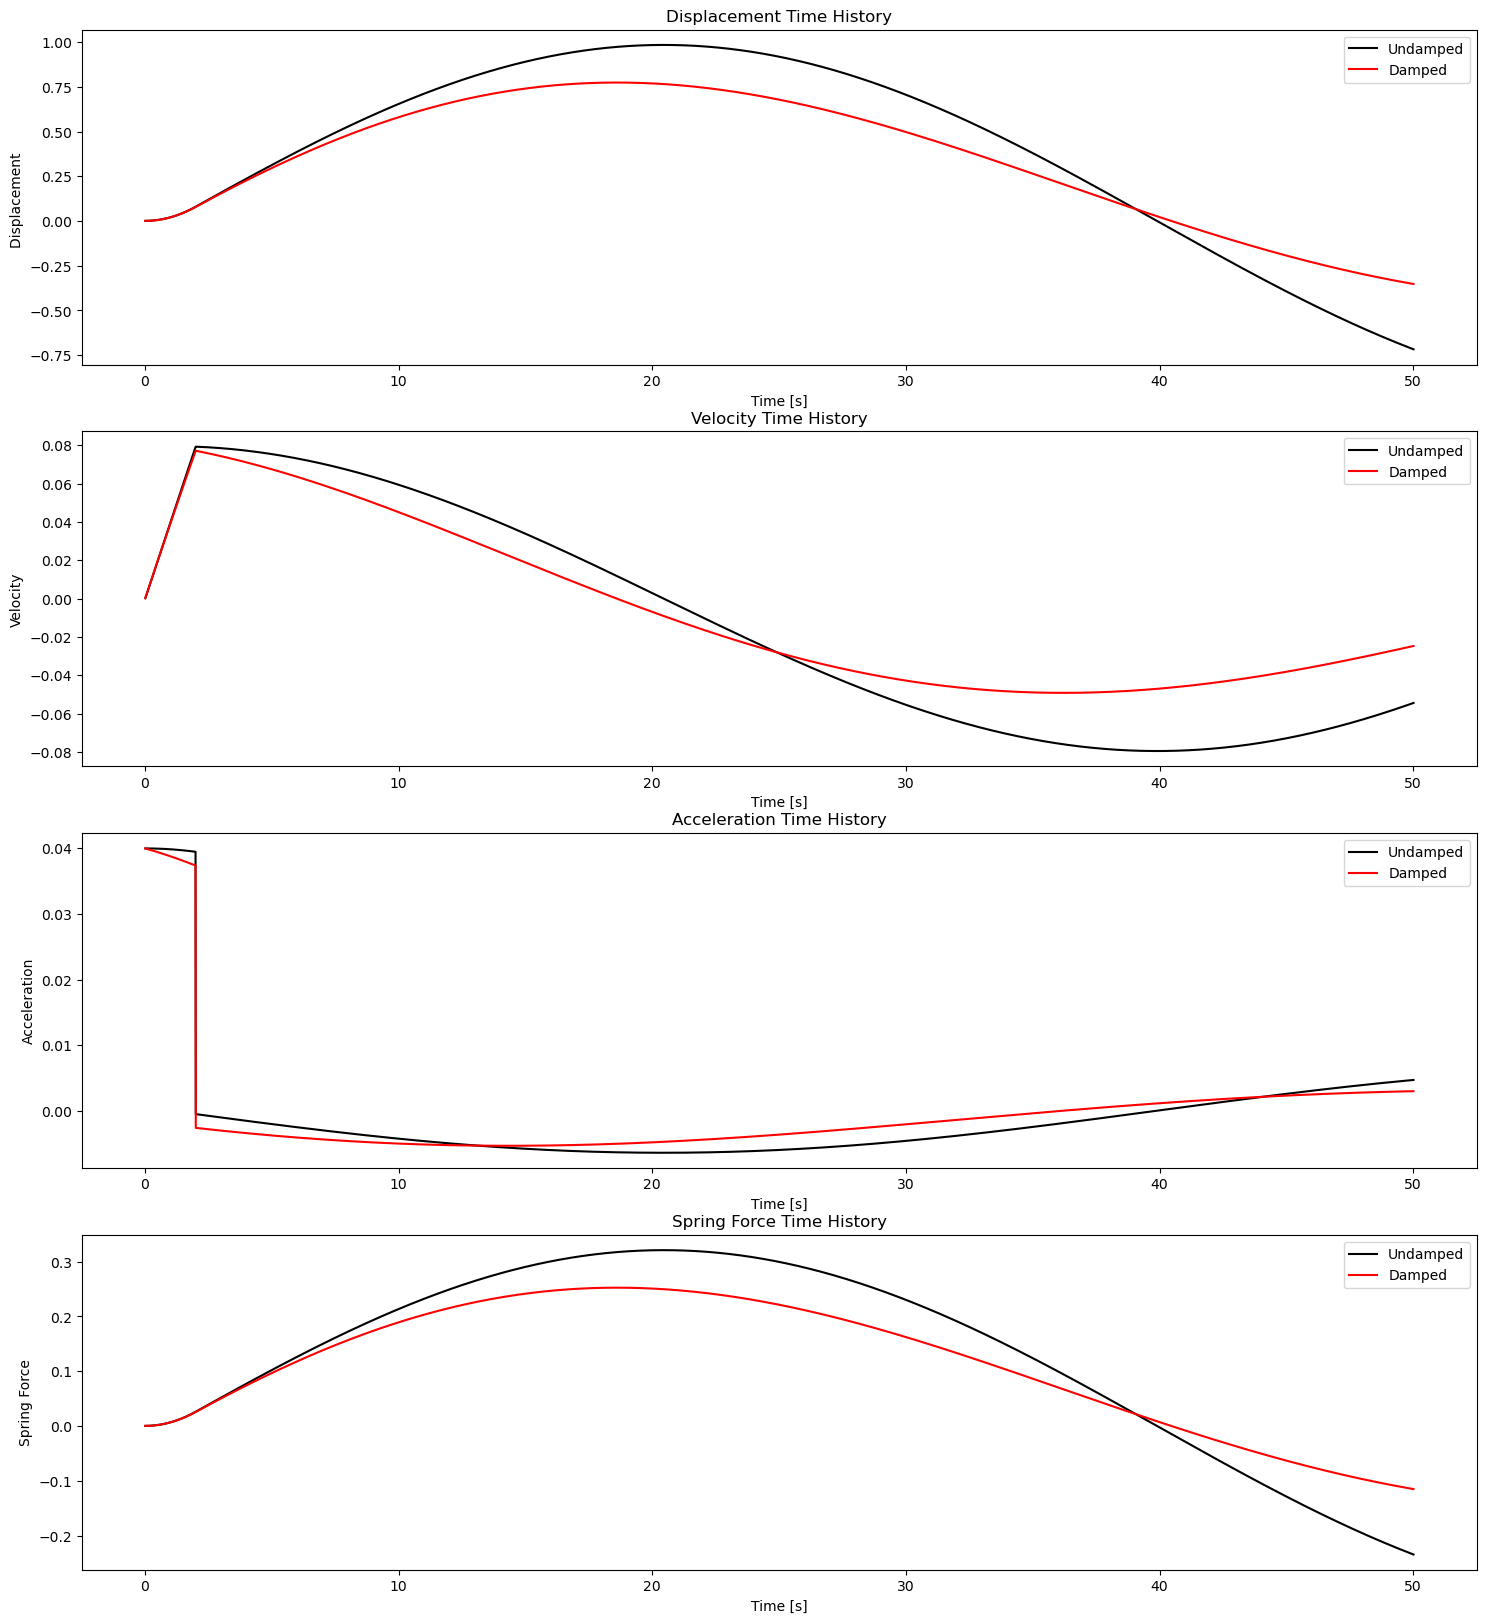

In [8]:
#          #####################################################################################
#          #                                  IN THE NAME OF ALLAH                             #
#          #          FREE VIBRATION ANAYSIS OF INELASTIC SPRING WITH PULSE LOADING            #
#          #-----------------------------------------------------------------------------------#
#          #              THIS PROGRAM WRITTEN BY SALAR DELAVAR GHASHGHAEI (QASHQAI)           #
#          #                       EMAIL: salar.d.ghashghaei@gmail.com                         #
#          #####################################################################################

import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt

# Set up variables
e = 210.0e3  # Modulus of elasticity (Young's modulus)
A = 0.25  # Cross-sectional area of the element
l = 1000.0  # Length of the element
k = (e*A)/l # Truss Axial Stiffness
m = 50.0  # Mass of the node
u0 = 0.001  # Initial displacement applied to the node
damping_ratio = 0.02  # Damping ratio

# Set analysis parameters
duration = 50.0 # [s] 50 Seconds
dt = 0.01 # time step

# Define ReinforcingSteel material properties
fy = 400.0  # Yield strength of steel
Es = 210.0e3  # Modulus of elasticity
fu = 600.0  # Ultimate strength
Esh = 20.0e3  # Hardening modulus
esh = 0.01  # Strain at start of hardening
esu = 0.1  # Ultimate strain

# Pulse loading parameters
START_TIME = 2.0
END_TIME = 6.0
PERIOD = 1.2
LOAD_FACTOR = 2.0  # Amplitude Factor
PULSEWIDTH = 2.5 # Pulse width as a fraction of the period

def perform_analysis(damping=False):
    # Set up the model
    ops.wipe()
    ops.model('basic', '-ndm', 2, '-ndf', 3)

    # Define nodes
    ops.node(1, 0, 0)
    ops.node(2, l, 0)

    # Define boundary conditions
    ops.fix(1, 1, 1, 1)
    ops.fix(2, 0, 1, 1)

    # Define mass
    ops.mass(2, m, 0, 0)

    # Define material
    ops.uniaxialMaterial('ReinforcingSteel', 1, fy, Es, fu, Esh, esh, esu)

    # Define element
    ops.element('Truss', 1, 1, 2, A, 1)

    # Static analysis to apply initial displacement
    ops.timeSeries('Linear', 1)
    ops.pattern('Plain', 1, 1)
    ops.load(2, 1.0, 0, 0)

    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('BandGeneral')
    ops.algorithm('Newton')
    ops.test('NormDispIncr', 1.0e-8, 10)
    ops.integrator('DisplacementControl', 2, 1, u0)
    ops.analysis('Static')
    ops.analyze(1)

    ops.setTime(0.0)

    # Wipe analysis and reset time
    ops.wipeAnalysis()
    ops.remove('loadPattern', 1)
    ops.system('UmfPack')
    # Define pulse loading 
    #ops.timeSeries('Pulse', 2, START_TIME, END_TIME, PERIOD, '-width', PULSEWIDTH, '-factor', LOAD_FACTOR)
    ops.timeSeries('Rectangular',  2, 0.0, 2.0, '-factor', 2.0)
    ops.pattern('Plain', 2, 2)
    ops.load(2, 1.0, 0, 0)

    # Dynamic analysis
    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('UmfPack')
    ops.test('NormDispIncr', 1.0e-8, 10)
    ops.integrator('Newmark', 0.5, 0.25)
    ops.algorithm('Newton')

    if damping:
        # Calculate Rayleigh damping factors
        omega1 = np.sqrt(k / m)
        omega2 = 2 * omega1  # Just an assumption for two modes
        a0 = damping_ratio * (2 * omega1 * omega2) / (omega1 + omega2)
        a1 = damping_ratio * 2 / (omega1 + omega2)
        # Apply Rayleigh damping
        ops.rayleigh(a0, a1, 0, 0)

    ops.analysis('Transient')

    # Perform transient analysis and store results
    time = []
    displacement = []
    velocity = []
    acceleration = []
    spring_force = []

    stable = 0
    current_time = 0.0

    while stable == 0 and current_time < duration:
        stable = ops.analyze(1, dt)
        current_time = ops.getTime()
        time.append(current_time)
        displacement.append(ops.nodeDisp(2, 1))
        velocity.append(ops.nodeVel(2, 1))
        acceleration.append(ops.nodeAccel(2, 1))
        spring_force.append(-ops.eleResponse(1, 'force')[0])

    return time, displacement, velocity, acceleration, spring_force

# Perform analyses
time_undamped, displacement_undamped, velocity_undamped, acceleration_undamped, spring_force_undamped = perform_analysis(damping=False)
time_damped, displacement_damped, velocity_damped, acceleration_damped, spring_force_damped = perform_analysis(damping=True)

### PLOT THE TIME HISTORY:
PLOT_4_CHART()